<a href="https://colab.research.google.com/github/EladAriel/Tensorflow/blob/main/Tensorflow_uc_merced_dataset_CNN_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

### Download The uc_merced DataSet

In [2]:
# Download the uc_merced DataSet
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'uc_merced',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True 
)

The uc_merced dataset number of classes:

In [3]:
# Print the number of classes
num_classes = metadata.features['label'].num_classes
print(f"There are {num_classes} classes") 

There are 21 classes


The uc_merced dataset classes names:

In [4]:
# Print the classes names
class_names = metadata.features['label'].names
print(class_names)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


View an image

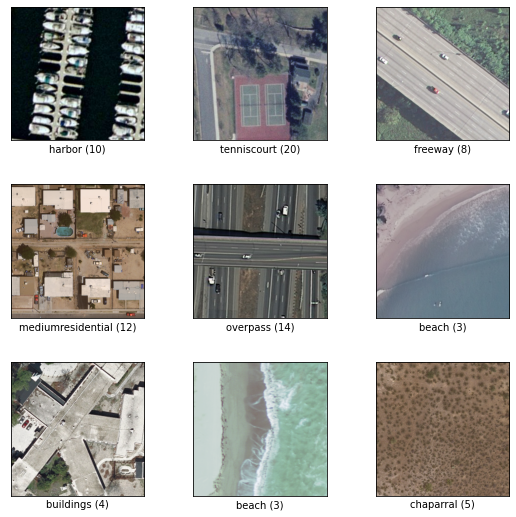

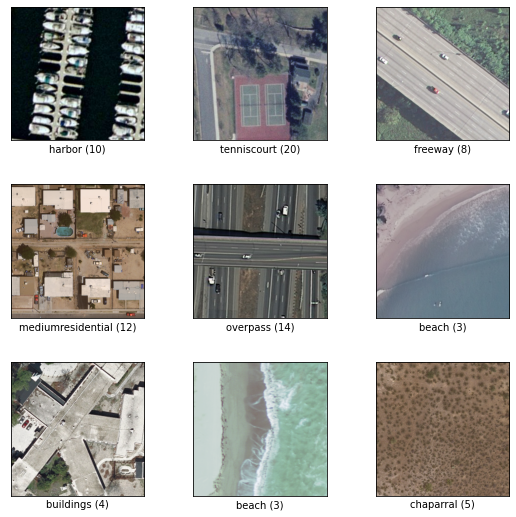

In [5]:
# View some examples
fig = tfds.show_examples(train_ds, metadata)
fig

In [6]:
# Find the image shape
for image_batch, labels_batch in train_ds:
  print(f"The image shape is: (width, height, colour channels) = {image_batch.shape}")
  break

The image shape is: (width, height, colour channels) = (256, 256, 3)


### Preproccessing - Standardize the data

In [7]:
# Create help function to prepare the dataset
def prepare_ds(dataset, IMG_SIZE = 224, batch_size=32 ,shuffle=False, augment = False):
  AUTOTUNE = tf.data.AUTOTUNE
  # Resize and rescale all datasets
  resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
  ])
  ds = dataset.map(lambda x, y: (resize_and_rescale(x), y),
                   num_parallel_calls=AUTOTUNE)
  
  if shuffle:
    ds = ds.shuffle(1000)
  
  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
    ])
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                     num_parallel_calls =AUTOTUNE)
  
  # Use buffered prefetching on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Use the help function on the dataset
train_ds_norm = prepare_ds(train_ds, shuffle=True, augment=True)
val_ds_norm = prepare_ds(val_ds)
test_ds_norm = prepare_ds(test_ds)

In [9]:
# Check for the first image
image_batch, labels_batch = next(iter(train_ds_norm))
first_image = image_batch[0]
print(f"The pixel values are now in {[np.min(first_image), np.max(first_image)]}")

The pixel values are now in [0.04988867, 0.99852544]


### Train a model

In [10]:
# 1. Create a model
model = Sequential([
  Conv2D(21, 3, activation='relu', input_shape=(224,224, 3)),
  MaxPool2D(),
  Conv2D(21, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(21, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(21, activation='softmax')
])

# 2. Compile the model
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 3. Fit a model
history = model.fit(train_ds_norm,
                    epochs=5,
                    steps_per_epoch=len(train_ds_norm),
                    validation_data=val_ds_norm,
                    validation_steps=len(val_ds_norm))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 21s 197ms/step - loss: 2.9393 - accuracy: 0.0655 - val_loss: 2.7973 - val_accuracy: 0.1095
Epoch 2/5
53/53 [==============================] - 12s 181ms/step - loss: 2.6022 - accuracy: 0.1982 - val_loss: 2.4063 - val_accuracy: 0.2952
Epoch 3/5
53/53 [==============================] - 13s 198ms/step - loss: 2.1836 - accuracy: 0.3262 - val_loss: 1.9891 - val_accuracy: 0.4333
Epoch 4/5
53/53 [==============================] - 12s 178ms/step - loss: 1.8554 - accuracy: 0.4268 - val_loss: 1.6875 - val_accuracy: 0.5095
Epoch 5/5
53/53 [==============================] - 12s 178ms/step - loss: 1.6465 - accuracy: 0.4881 - val_loss: 1.7860 - val_accuracy: 0.4333


In [11]:
# Plot the validation and training data separately
def plot_loss_curves (history):
  """
  Returns separate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

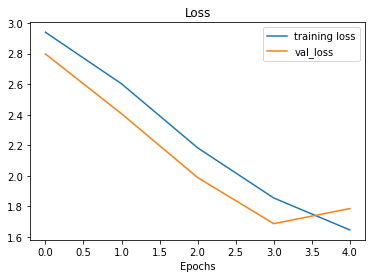

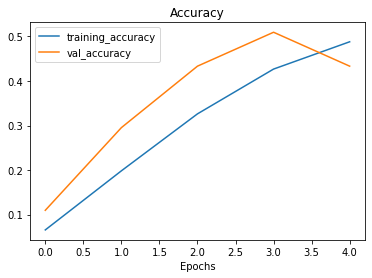

In [12]:
# Plot the validation and training data separately
plot_loss_curves(history)

In [13]:
# Check the model's architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 21)      588       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 21)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 21)      3990      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 21)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 21)        3990      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 21)      

### Adjust the model parameters

#### Model 2 - Increase the number of epochs

In [14]:
# 1. Create a model
model_2 = Sequential([
  Conv2D(21, 3, activation='relu', input_shape=(224,224, 3)),
  MaxPool2D(),
  Conv2D(21, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(21, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(21, activation='softmax')
])

# 2. Compile the model
model_2.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 3. Fit a model
history_2 = model_2.fit(train_ds_norm,
                    epochs=20,
                    steps_per_epoch=len(train_ds_norm),
                    validation_data=val_ds_norm,
                    validation_steps=len(val_ds_norm))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 13s 183ms/step - loss: 2.8826 - accuracy: 0.0911 - val_loss: 2.6172 - val_accuracy: 0.1857
Epoch 2/20
53/53 [==============================] - 12s 181ms/step - loss: 2.4644 - accuracy: 0.2375 - val_loss: 2.1745 - val_accuracy: 0.3143
Epoch 3/20
53/53 [==============================] - 12s 179ms/step - loss: 2.1310 - accuracy: 0.3411 - val_loss: 2.0528 - val_accuracy: 0.3762
Epoch 4/20
53/53 [==============================] - 12s 178ms/step - loss: 2.0114 - accuracy: 0.3524 - val_loss: 1.8834 - val_accuracy: 0.4333
Epoch 5/20
53/53 [==============================] - 12s 178ms/step - loss: 1.8196 - accuracy: 0.4208 - val_loss: 1.8887 - val_accuracy: 0.4714
Epoch 6/20
53/53 [==============================] - 12s 179ms/step - loss: 1.6715 - accuracy: 0.4893 - val_loss: 1.7601 - val_accuracy: 0.4667
Epoch 7/20
53/53 [==============================] - 12s 180ms/step - loss: 1.5859 - accuracy: 0.5071 - val_loss: 1.5082 - val_accuracy: 0.5333
Epoch 8/20

In [15]:
# Check the model's architecture
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 21)      588       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 21)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 21)      3990      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 21)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 21)        3990      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 21)      

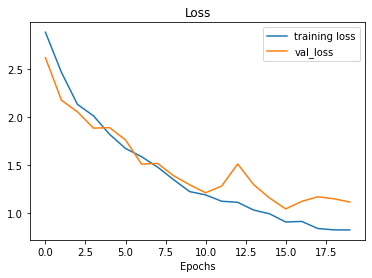

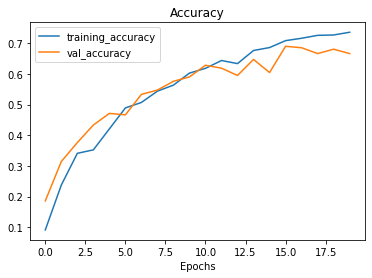

In [16]:
# Plot the validation and training data separately
plot_loss_curves(history_2)

In [17]:
# Evaluate the model
model_2.evaluate(test_ds_norm)

7/7 [==============================] - 1s 83ms/step - loss: 1.0484 - accuracy: 0.6714


[1.048380970954895, 0.6714285612106323]

#### Model 3 - Increase the number of model layers, Increase the number of filters in each convolutional layer & Finding an ideal learning rate

In [18]:
# 1. Create a model
model_3 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224,224, 3)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, activation='relu'),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(21, activation='softmax')
])

# 2. Compile the model
model_3.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from

# 3. Fit a model
history_3 = model_3.fit(train_ds_norm,
                    epochs=50,
                    callbacks=[lr_scheduler],
                    steps_per_epoch=len(train_ds_norm),
                    validation_data=val_ds_norm,
                    validation_steps=len(val_ds_norm))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 17s 220ms/step - loss: 2.9608 - accuracy: 0.0833 - val_loss: 2.7896 - val_accuracy: 0.1476 - lr: 1.0000e-04
Epoch 2/50
53/53 [==============================] - 14s 206ms/step - loss: 2.5363 - accuracy: 0.2024 - val_loss: 2.3484 - val_accuracy: 0.2952 - lr: 1.1220e-04
Epoch 3/50
53/53 [==============================] - 14s 218ms/step - loss: 2.2323 - accuracy: 0.3196 - val_loss: 2.1646 - val_accuracy: 0.3714 - lr: 1.2589e-04
Epoch 4/50
53/53 [==============================] - 14s 202ms/step - loss: 2.0382 - accuracy: 0.3619 - val_loss: 2.0841 - val_accuracy: 0.3476 - lr: 1.4125e-04
Epoch 5/50
53/53 [==============================] - 14s 201ms/step - loss: 1.8755 - accuracy: 0.4071 - val_loss: 1.7937 - val_accuracy: 0.4619 - lr: 1.5849e-04
Epoch 6/50
53/53 [==============================] - 13s 202ms/step - loss: 1.7607 - accuracy: 0.4435 - val_loss: 1.7230 - val_accuracy: 0.4619 - lr: 1.7783e-04
Epoch 7/50
53/53 [==============================] -

In [19]:
# Check the model's architecture
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                  

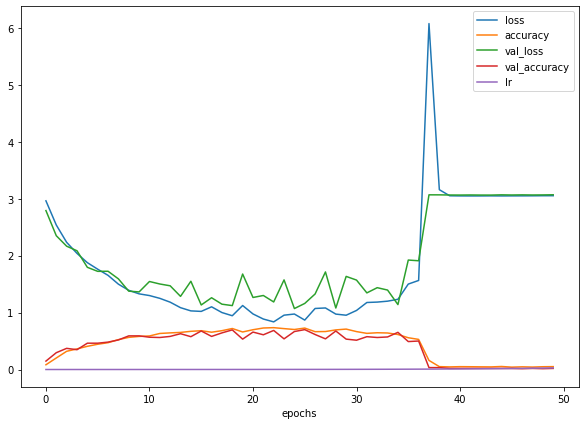

In [20]:
# Checkout the history
import pandas as pd
pd.DataFrame(history_3.history).plot(figsize=(10,7), xlabel="epochs");

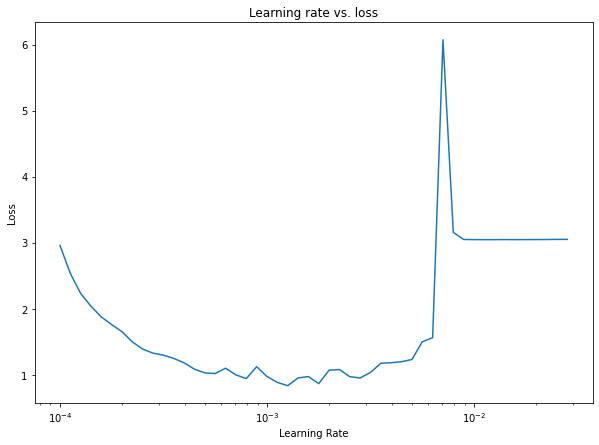

In [21]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(50)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_3.history['loss']) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

To figure out the ideal value of the learning rate (at least the ideal value to begin training our model), the learning rate value where the loss is still decreasing but not quite flattened out is: lr = 0.00013

#### Model 4 - The adjusted model

In [22]:
# 1. Create a model
model_4 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224,224, 3)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, activation='relu'),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(21, activation='softmax')
])

# 2. Compile the model
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00013),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 3. Fit a model
history_4 = model_4.fit(train_ds_norm,
                    epochs=24,
                    steps_per_epoch=len(train_ds_norm),
                    validation_data=val_ds_norm,
                    validation_steps=len(val_ds_norm))

Epoch 1/24


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 18s 214ms/step - loss: 2.9217 - accuracy: 0.0923 - val_loss: 2.6516 - val_accuracy: 0.1810
Epoch 2/24
53/53 [==============================] - 17s 258ms/step - loss: 2.3844 - accuracy: 0.2577 - val_loss: 2.2122 - val_accuracy: 0.3333
Epoch 3/24
53/53 [==============================] - 13s 201ms/step - loss: 2.0742 - accuracy: 0.3696 - val_loss: 2.0554 - val_accuracy: 0.4095
Epoch 4/24
53/53 [==============================] - 14s 205ms/step - loss: 1.8615 - accuracy: 0.4304 - val_loss: 1.9056 - val_accuracy: 0.4286
Epoch 5/24
53/53 [==============================] - 15s 220ms/step - loss: 1.7423 - accuracy: 0.4435 - val_loss: 1.7659 - val_accuracy: 0.4429
Epoch 6/24
53/53 [==============================] - 13s 201ms/step - loss: 1.6076 - accuracy: 0.4887 - val_loss: 1.6646 - val_accuracy: 0.4714
Epoch 7/24
53/53 [==============================] - 14s 212ms/step - loss: 1.4943 - accuracy: 0.5137 - val_loss: 1.5030 - val_accuracy: 0.5476
Epoch 8/24

In [23]:
# Check the model's architecture
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 106, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                  

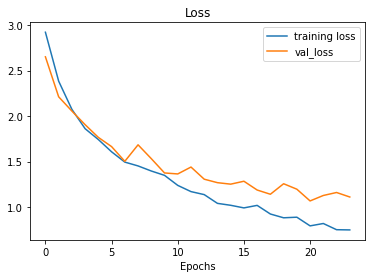

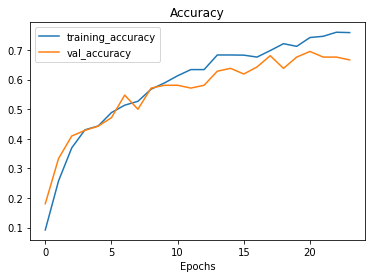

In [24]:
# Plot the validation and training data separately
plot_loss_curves(history_4)

In [25]:
# Evaluate the model
model_4.evaluate(test_ds_norm)

7/7 [==============================] - 1s 92ms/step - loss: 0.9865 - accuracy: 0.6714


[0.9865024089813232, 0.6714285612106323]

In [31]:
# Comparing model_4 to all other models
model.evaluate(test_ds_norm)

7/7 [==============================] - 1s 127ms/step - loss: 1.7737 - accuracy: 0.4333


[1.7736876010894775, 0.4333333373069763]

In [32]:
model_2.evaluate(test_ds_norm)

7/7 [==============================] - 1s 120ms/step - loss: 1.0484 - accuracy: 0.6714


[1.048380970954895, 0.6714285612106323]

There is no such difference between model_2 and model_4 in terms of loss and accuracy. The only difference is that model_2 has `Total params: 306,705` and model_4 has `Total params: 3,840,885`. Hence, I'll use model_2.

### Making a prediction with the trained model

In [26]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [27]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

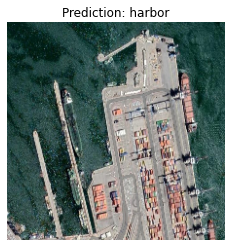

In [34]:
# Import an image, make a prediction on it with a trained model and plots the image with the predicted class
pred_and_plot(model=model_2, filename="01-Ship.jpeg", class_names=class_names)

It is Haifa Port!

### Save the model

In [35]:
# Save the model
model_2.save("uc_merced_trained_model")

INFO:tensorflow:Assets written to: uc_merced_trained_model/assets


INFO:tensorflow:Assets written to: uc_merced_trained_model/assets
